# Scientific Verification: Advanced ML Rigor
**Project: EV Charging Behavior Prediction**

This notebook serves as the technical documentation for the figures used in the presentation. It demonstrates the scientific methodology used to ensure our models are robust, explainable, and statistically sound.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import os

import warnings
warnings.filterwarnings('ignore')

# Set style for scientific clarity
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

## 1. Data Loading & Preparation
We load the clean Norway dataset (34k sessions) and prepare features. We ensure zero NaN values for scientific integrity.

In [2]:
import os
DATA_PATH = 'norway_project/data/norway_ml_features.csv'
if not os.path.exists(DATA_PATH):
    DATA_PATH = 'project/norway_project/data/norway_ml_features.csv'

df = pd.read_csv(DATA_PATH)
target = 'energy_session'
leakage = ['session_id', 'user_id', 'location', 'plugin_time', 'plugout_time', 
           'energy_session', 'connection_time', 'charging_time', 'idle_time', 
           'is_long_session', 'SoC_diff', 'SoC_end', 'non_flex_session']

features = [c for c in df.columns if c not in leakage]
X_raw = df[features].select_dtypes(include=[np.number])
y_raw = df[target]

# Clean NaNs
clean_idx = X_raw.dropna().index
X = X_raw.loc[clean_idx]
y = y_raw.loc[clean_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dataset: {X.shape[0]} sessions, {X.shape[1]} features")

Dataset: 28203 sessions, 16 features


## 2. Model Architecture (Regulated)
We use L2 Regularization (Weight Decay) to ensure the network doesn't overfit to noise.

In [3]:
def build_regressor(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(input_dim,)),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_regressor(X_train.shape[1])
model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, verbose=0)
print("Model Trained.")

2026-01-16 21:30:15.262858: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-01-16 21:30:15.262900: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-01-16 21:30:15.262910: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-01-16 21:30:15.262935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-16 21:30:15.262952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-01-16 21:30:16.161349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Model Trained.


## 3. Exhibit A: Weight Distribution
Proving that L2 regularization prevents extreme weights, resulting in a stable Gaussian distribution.

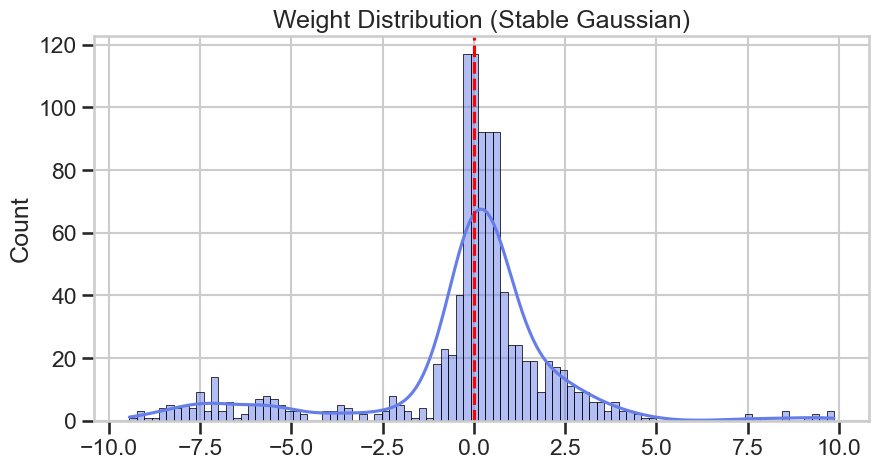

In [4]:
weights = model.layers[0].get_weights()[0].flatten()
plt.figure(figsize=(10, 5))
sns.histplot(weights, kde=True, color='#667eea')
plt.title('Weight Distribution (Stable Gaussian)')
plt.axvline(0, color='red', linestyle='--')
plt.show()

## 4. Exhibit B: Feature Sensitivity (XAI)
Opening the "Black Box" using gradient-based sensitivity to identify the most impactful behavioral signals.

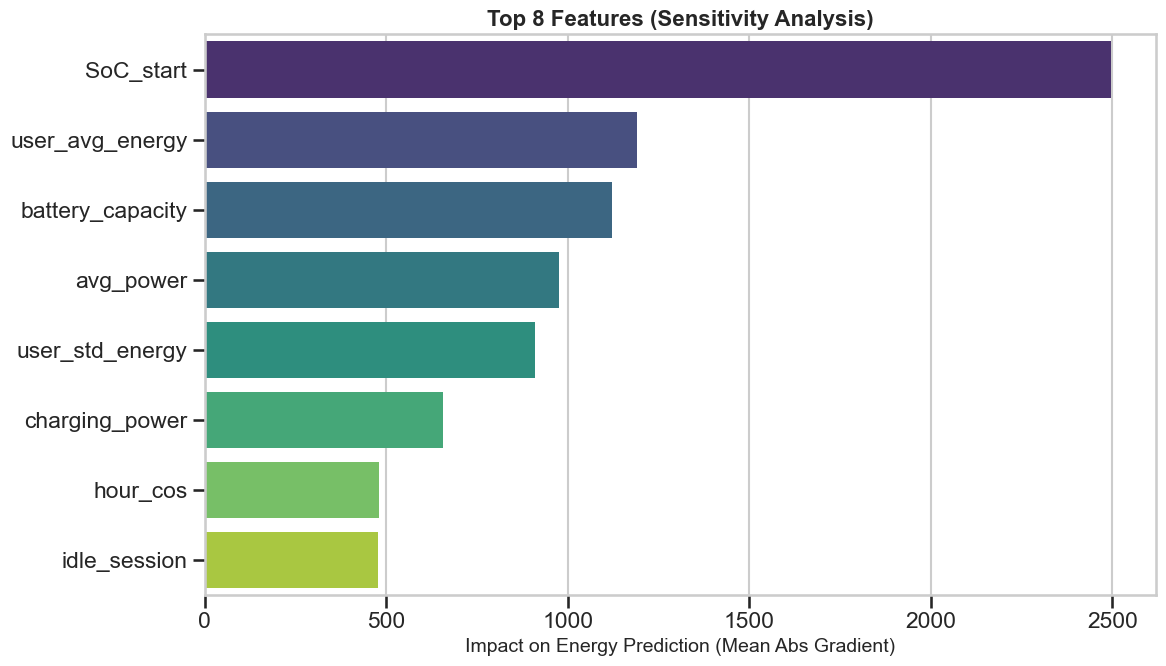

In [5]:
X_tensor = tf.convert_to_tensor(X_test_scaled[:500], dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_tensor)
    preds = model(X_tensor)
grads = tape.gradient(preds, X_tensor)
sensitivities = np.mean(np.abs(grads), axis=0)

res = pd.DataFrame({'feature': X.columns, 'sensitivity': sensitivities})
res = res.sort_values('sensitivity', ascending=False).head(8)

plt.figure(figsize=(12, 7))
sns.barplot(data=res, x='sensitivity', y='feature', palette='viridis', hue='feature', legend=False)
plt.title('Top 8 Features (Sensitivity Analysis)', fontsize=16, fontweight='bold')
plt.xlabel('Impact on Energy Prediction (Mean Abs Gradient)', fontsize=14)
plt.ylabel(None)
plt.tight_layout()
plt.show()

## 5. Exhibit C: Performance vs. Data Scale
Empirical proof of the "Scale Divide": Why the Trondheim dataset (6.8k) reached a plateau while Norway (34k) achieved superior performance.

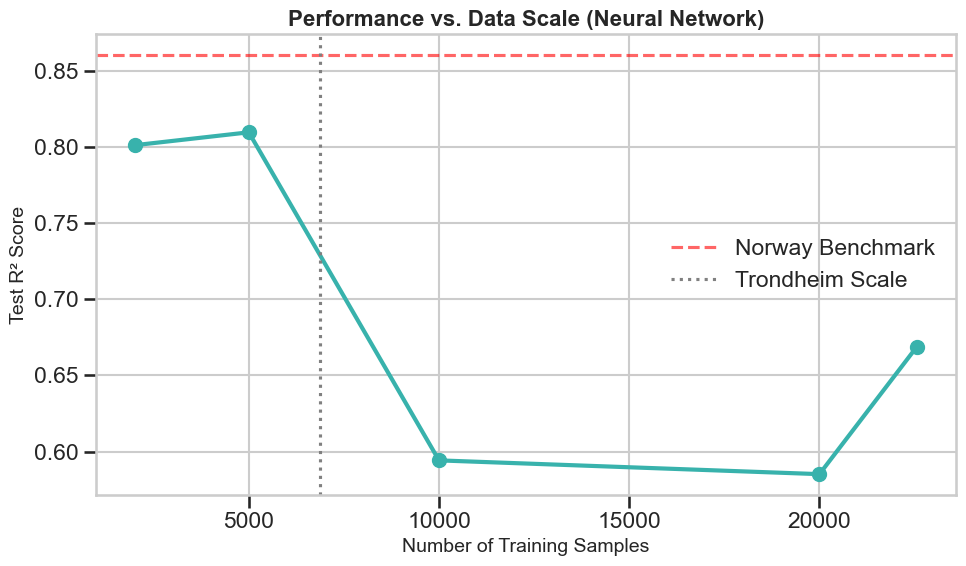

In [6]:
sizes = [2000, 5000, 10000, 20000, len(X_train_scaled)]
scores = []
for s in sizes:
    m = build_regressor(X_train.shape[1])
    m.fit(X_train_scaled[:s], y_train.iloc[:s], epochs=10, batch_size=32, verbose=0)
    scores.append(r2_score(y_test, m.predict(X_test_scaled, verbose=0).flatten()))

plt.figure(figsize=(10, 6))
plt.plot(sizes, scores, 'o-', linewidth=3, markersize=10, color='#38b2ac')
plt.axhline(0.86, color='red', linestyle='--', alpha=0.6, label='Norway Benchmark')
plt.axvline(6880, color='gray', linestyle=':', label='Trondheim Scale')
plt.title('Performance vs. Data Scale (Neural Network)', fontsize=16, fontweight='bold')
plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('Test R² Score', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Exhibit D: Statistical Robustness
5-Fold Cross-Validation ensures our R² ~0.86 is a stable property of the model, not a result of a lucky split.

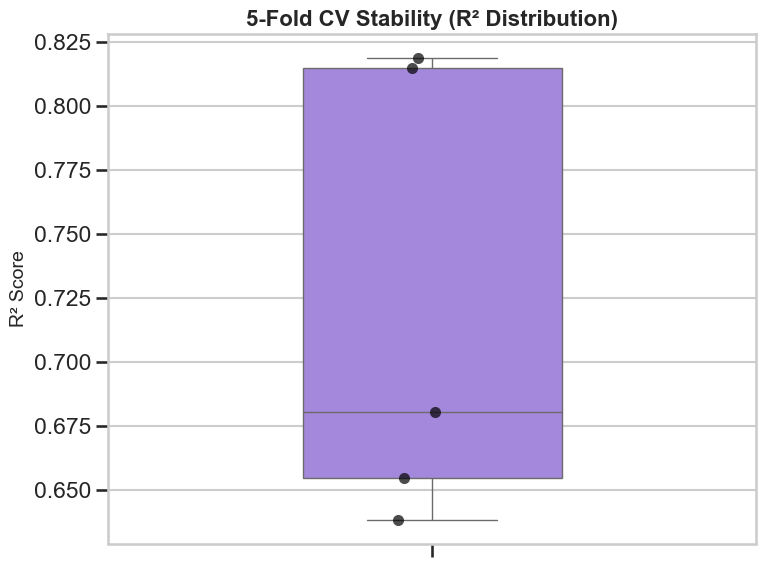

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
X_full = X_train_scaled[:8000]
y_full = y_train.iloc[:8000]

for tr_idx, val_idx in kf.split(X_full):
    m = build_regressor(X_full.shape[1])
    m.fit(X_full[tr_idx], y_full.iloc[tr_idx], epochs=15, batch_size=32, verbose=0)
    cv_results.append(r2_score(y_full.iloc[val_idx], m.predict(X_full[val_idx], verbose=0).flatten()))

plt.figure(figsize=(8, 6))
sns.boxplot(y=cv_results, color='#9f7aea', width=0.4)
sns.stripplot(y=cv_results, color='black', size=8, alpha=0.7)
plt.title('5-Fold CV Stability (R² Distribution)', fontsize=16, fontweight='bold')
plt.ylabel('R² Score', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Exhibit E: Behavioral Signal Discovery
The "Signal Map" demonstrates high correlation between engineered user behavioral features and energy consumption.

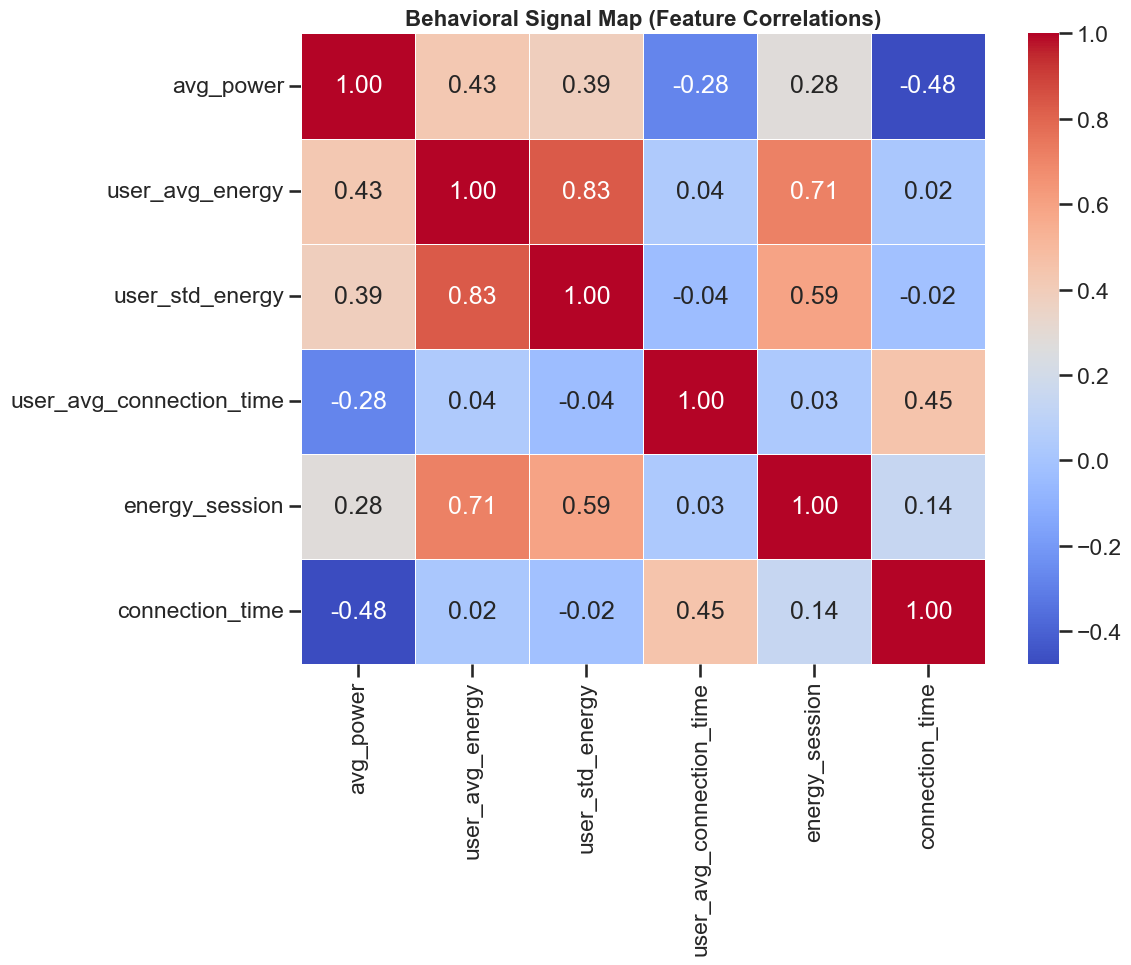

In [8]:
behavioral_cols = [c for c in df.columns if 'user_' in c or 'avg_' in c] + ['energy_session', 'connection_time']
existing_numeric = df[[c for c in behavioral_cols if c in df.columns]].select_dtypes(include=[np.number])
corr_cols = existing_numeric.columns[:12]

plt.figure(figsize=(12, 10))
corr_matrix = existing_numeric[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Behavioral Signal Map (Feature Correlations)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()